In [1]:
!pip install transformers datasets torchvision torchaudio gtts accelerate  -q
!pip install datasets --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration, Trainer, TrainingArguments, default_data_collator
from datasets import load_dataset
from PIL import Image, UnidentifiedImageError
import os
from tqdm.auto import tqdm


In [3]:
from datasets import load_dataset
!pip install datasets --upgrade
ds = load_dataset("LearnItAnyway/Visual-Navigation-21k",split="train[:1000]")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/766 [00:00<?, ?B/s]

Vis-Nav-21k.json:   0%|          | 0.00/59.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/21695 [00:00<?, ? examples/s]

In [4]:
ds

Dataset({
    features: ['conversations', 'image', 'id', 'description'],
    num_rows: 1000
})

In [5]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [6]:
def custom_data_collator(features):
    # First, let's process the image paths to actual images
    images = []
    valid_features = []  # To store features with successfully loaded images
    for feature in features:
        image_path = feature['image']
        try:
            image = Image.open(image_path).convert('RGB')
            images.append(image)
            valid_features.append(feature)  # Add the feature if image loading is successful
        except (FileNotFoundError, UnidentifiedImageError, OSError) as e:  # Handle more potential errors
            print(f"Error loading image from path: {image_path}. Error: {e}")
            # Skip this feature and proceed to the next one

    # Check if valid_features is empty (no images loaded successfully)
    if not valid_features:
        print("All features in batch had image loading issues, skipping this batch")
        # Return an empty dictionary with the necessary keys, but empty tensors
        return {
            'input_ids': torch.empty((0, 0), dtype=torch.long),
            'attention_mask': torch.empty((0, 0), dtype=torch.long),
            'labels': torch.empty((0, 0), dtype=torch.long),
            'pixel_values': torch.empty((0, 3, 224, 224), dtype=torch.float32), # Assuming standard BLIP input size
        }

    # Now, process the images and instructions using the BLIP processor
    # Access the 'description' key, as it is the correct label key in this dataset
    inputs = processor(images=images, text=[feature["description"] for feature in valid_features], return_tensors="pt", padding=True)

    # Remove the original 'image' key and add pixel values
    del inputs['image']
    inputs['pixel_values'] = inputs.pop("images")  # Rename 'images' key to 'pixel_values'

    # Add labels to the inputs dictionary
    inputs['labels'] = inputs['input_ids'].detach().clone()

    return inputs

In [7]:
training_args = TrainingArguments(
    output_dir="./blip-finetuned",
    num_train_epochs=3,
    per_device_train_batch_size=2,
    save_steps=500,
    save_total_limit=2,
    remove_unused_columns=False,
    logging_dir="./logs",
    logging_steps=10,
    fp16=True,  # Set True to use Colab GPU efficiently
    report_to="none"  # Disable wandb integration
)

In [8]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds,
    data_collator=custom_data_collator
)

# Start the training process
trainer.train()

Error loading image from path: MP_SEL_054355.jpg. Error: [Errno 2] No such file or directory: 'MP_SEL_054355.jpg'
Error loading image from path: MP_SEL_063970.jpg. Error: [Errno 2] No such file or directory: 'MP_SEL_063970.jpg'
All features in batch had image loading issues, skipping this batch
Error loading image from path: MP_SEL_052881.jpg. Error: [Errno 2] No such file or directory: 'MP_SEL_052881.jpg'
Error loading image from path: MP_SEL_061135.jpg. Error: [Errno 2] No such file or directory: 'MP_SEL_061135.jpg'
All features in batch had image loading issues, skipping this batch


Step,Training Loss
10,0.000000
20,0.000000
30,0.000000
40,0.000000
50,0.000000
60,0.000000
70,0.000000
80,0.000000
90,0.000000
100,0.000000


Error loading image from path: MP_SEL_061242.jpg. Error: [Errno 2] No such file or directory: 'MP_SEL_061242.jpg'
Error loading image from path: MP_SEL_062575.jpg. Error: [Errno 2] No such file or directory: 'MP_SEL_062575.jpg'
All features in batch had image loading issues, skipping this batch
Error loading image from path: MP_SEL_061103.jpg. Error: [Errno 2] No such file or directory: 'MP_SEL_061103.jpg'
Error loading image from path: MP_SEL_054534.jpg. Error: [Errno 2] No such file or directory: 'MP_SEL_054534.jpg'
All features in batch had image loading issues, skipping this batch
Error loading image from path: MP_SEL_052399.jpg. Error: [Errno 2] No such file or directory: 'MP_SEL_052399.jpg'
Error loading image from path: MP_SEL_062362.jpg. Error: [Errno 2] No such file or directory: 'MP_SEL_062362.jpg'
All features in batch had image loading issues, skipping this batch
Error loading image from path: MP_SEL_063507.jpg. Error: [Errno 2] No such file or directory: 'MP_SEL_063507.jpg

TrainOutput(global_step=1500, training_loss=0.0, metrics={'train_runtime': 275.3045, 'train_samples_per_second': 10.897, 'train_steps_per_second': 5.449, 'total_flos': 0.0, 'train_loss': 0.0, 'epoch': 3.0})

In [9]:
# After the trainer.train() call, save the processor:
trainer.save_model("./blip-finetuned") # This will save the model
processor.save_pretrained("./blip-finetuned") # This will save the processor

[]

In [23]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch

# Load fine-tuned processor and model
processor = BlipProcessor.from_pretrained("./blip-finetuned")
model = BlipForConditionalGeneration.from_pretrained("./blip-finetuned").to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# 🔁 Replace with your uploaded filename if different
image_path = "team.jpg"  # 👈 change this if your image has another name
image = Image.open(image_path).convert("RGB")

# Generate caption
inputs = processor(images=image, return_tensors="pt").to(model.device)
with torch.no_grad():
    output = model.generate(**inputs)
caption = processor.decode(output[0], skip_special_tokens=True)

# Show result
print("📝 Generated Caption:", caption)
image.show()


📝 Generated Caption: business team stock photos


In [ ]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch
import cv2
import os

# Load fine-tuned model
processor = BlipProcessor.from_pretrained("./blip-finetuned")
model = BlipForConditionalGeneration.from_pretrained("./blip-finetuned")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device).eval()

# Set video path
video_path = "cars.mp4"  # ✅ replace this if your filename is different
frame_dir = "frames"
os.makedirs(frame_dir, exist_ok=True)

# Open video
cap = cv2.VideoCapture(video_path)
print(cap)
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_interval = fps  # Capture 1 frame per second
frame_idx = 0
captions = []

print("⏳ Generating captions for video frames...\n")
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_idx % frame_interval == 0:
        # Convert to RGB and PIL
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(rgb)

        # Run BLIP captioning
        inputs = processor(images=pil_image, return_tensors="pt").to(device)
        with torch.no_grad():
            output = model.generate(**inputs)
        caption = processor.decode(output[0], skip_special_tokens=True)

        # Save image + caption
        frame_path = os.path.join(frame_dir, f"frame_{frame_idx}.jpg")
        pil_image.save(frame_path)
        captions.append((frame_path, caption))
        print(f"🖼️ Frame {frame_idx // frame_interval}: {caption}")

    frame_idx += 1

cap.release()

# Summary
print("\n✅ All captions generated:")
for path, cap_text in captions:
    print(f"{os.path.basename(path)}: {cap_text}")


< cv2.VideoCapture 0x7eefa2610f50>
⏳ Generating captions for video frames...

🖼️ Frame 0: a view of a city street with cars and buildings
🖼️ Frame 1: a view of a city street with cars and buildings
🖼️ Frame 2: a view of a city street with cars and buildings
🖼️ Frame 3: a street with cars and buildings in the background
🖼️ Frame 4: a street with cars and buildings in the background
🖼️ Frame 5: a white car driving down a street next to a tree
🖼️ Frame 6: a street with cars and buses on it
🖼️ Frame 7: a view of a city street with cars and buildings
🖼️ Frame 8: a view of a city street with cars and buildings
🖼️ Frame 9: a view of a city street with cars and buildings
🖼️ Frame 10: a view of a city street with cars and buildings
🖼️ Frame 11: a street with cars and buildings in the background
🖼️ Frame 12: a view of a city street with cars and buildings

✅ All captions generated:
frame_0.jpg: a view of a city street with cars and buildings
frame_30.jpg: a view of a city street with cars and bu

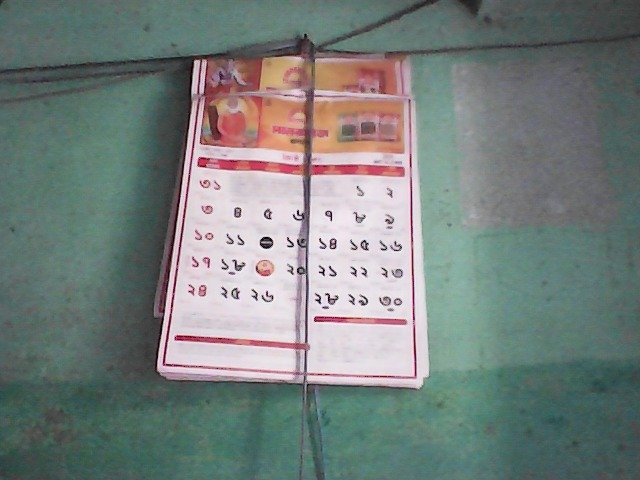

Generated Caption: a calendar hanging on a wall


In [25]:
from IPython.display import display
from google.colab import output
from PIL import Image
import io
import IPython
import cv2
import numpy as np
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration

# Load model and processor
processor = BlipProcessor.from_pretrained("./blip-finetuned")
model = BlipForConditionalGeneration.from_pretrained("./blip-finetuned")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device).eval()

# JavaScript to capture an image from webcam
def capture_image():
    js = """
    async function capture() {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = '📸 Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      video.width = 320;
      video.height = 240;
      div.appendChild(video);

      document.body.appendChild(div);

      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      video.srcObject = stream;
      await video.play();

      // Resize video to fit container
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getTracks().forEach(track => track.stop());
      div.remove();

      const dataUrl = canvas.toDataURL('image/jpeg');
      return dataUrl;
    }
    capture();
    """
    return output.eval_js(js)

def data_url_to_image(data_url):
    header, encoded = data_url.split(",", 1)
    binary = io.BytesIO(base64.b64decode(encoded))
    img = Image.open(binary)
    return img

import base64

# Capture image
data_url = capture_image()
image = data_url_to_image(data_url)

# Show captured image
display(image)

# Preprocess and caption
inputs = processor(images=image.convert("RGB"), return_tensors="pt").to(device)
with torch.no_grad():
    output = model.generate(**inputs, max_new_tokens=50)
caption = processor.decode(output[0], skip_special_tokens=True)

print("Generated Caption:", caption)


In [ ]:
from gtts import gTTS
from IPython.display import Audio

#Use the `caption` variable from the generated BLIP output
caption_text = caption  # your generated caption
print("Generated Caption:", caption_text)

# 🎧 Convert text to speech
tts = gTTS(text=caption_text, lang='en')
tts.save("caption_audio.mp3")

# Play audio in Colab
Audio("caption_audio.mp3")


📝 Generated Caption: a man in a room with a green wall


In [ ]:
!pip install gTTS opencv-python-headless transformers -q
from transformers import BlipProcessor, BlipForConditionalGeneration
from gtts import gTTS
from PIL import Image
from IPython.display import Audio, display
import torch
import cv2
import os

# Load BLIP model
processor = BlipProcessor.from_pretrained("./blip-finetuned")
model = BlipForConditionalGeneration.from_pretrained("./blip-finetuned").to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# Video path
video_path = "cars.mp4"  #  Replace with your uploaded video
output_audio_dir = "audio_outputs"
os.makedirs(output_audio_dir, exist_ok=True)

# Extract frames using OpenCV
cap = cv2.VideoCapture(video_path)
frame_rate = 1  # 1 frame per second
frame_interval = int(cap.get(cv2.CAP_PROP_FPS)) * frame_rate
frame_count = 0
caption_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_count % frame_interval == 0:
        # Convert frame to PIL image
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(rgb_frame)

        # Caption generation
        inputs = processor(images=image, return_tensors="pt").to(model.device)
        with torch.no_grad():
            output = model.generate(**inputs)
        caption = processor.decode(output[0], skip_special_tokens=True)
        print(f" Frame {frame_count} Caption:", caption)

        # Convert to audio
        tts = gTTS(text=caption, lang='en')
        audio_file = os.path.join(output_audio_dir, f"caption_{caption_count}.mp3")
        tts.save(audio_file)

        # Optional: Play audio in notebook
        display(Audio(audio_file))

        caption_count += 1

    frame_count += 1

cap.release()


🖼️ Frame 0 Caption: a view of a city street with cars and buildings


🖼️ Frame 30 Caption: a view of a city street with cars and buildings


🖼️ Frame 60 Caption: a view of a city street with cars and buildings


🖼️ Frame 90 Caption: a street with cars and buildings in the background


🖼️ Frame 120 Caption: a street with cars and buildings in the background


🖼️ Frame 150 Caption: a white car driving down a street next to a tree


🖼️ Frame 180 Caption: a street with cars and buses on it


🖼️ Frame 210 Caption: a view of a city street with cars and buildings


🖼️ Frame 240 Caption: a view of a city street with cars and buildings


🖼️ Frame 270 Caption: a view of a city street with cars and buildings


🖼️ Frame 300 Caption: a view of a city street with cars and buildings


🖼️ Frame 330 Caption: a street with cars and buildings in the background


🖼️ Frame 360 Caption: a view of a city street with cars and buildings


In [17]:
!pip install gradio gtts transformers torchvision opencv-python


In [12]:
import gradio as gr
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch
from gtts import gTTS
import tempfile
import os

# Load fine-tuned model
processor = BlipProcessor.from_pretrained("./blip-finetuned")
model = BlipForConditionalGeneration.from_pretrained("./blip-finetuned").to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

def caption_and_audio(image):
    # Generate caption
    inputs = processor(images=image, return_tensors="pt").to(model.device)
    with torch.no_grad():
        output = model.generate(**inputs)
    caption = processor.decode(output[0], skip_special_tokens=True)

    # Generate audio
    with tempfile.NamedTemporaryFile(delete=False, suffix=".mp3") as tmp_audio:
        tts = gTTS(text=caption)
        tts.save(tmp_audio.name)
        audio_path = tmp_audio.name

    return caption, audio_path

# Gradio UI
with gr.Blocks() as demo:
    gr.Markdown("## 🖼️ Image Captioning + Audio for Visually Impaired (BLIP + gTTS)")

    with gr.Row():
        image_input = gr.Image(type="pil", label="Upload Image")
        submit_btn = gr.Button("Generate Caption & Audio")

    caption_output = gr.Textbox(label="📝 Generated Caption", interactive=False)
    audio_output = gr.Audio(label="🔊 Audio Output")

    submit_btn.click(fn=caption_and_audio, inputs=image_input, outputs=[caption_output, audio_output])

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3d7e88ae35e55ac80b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [22]:
import gradio as gr
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch
import cv2
from gtts import gTTS
import os
import tempfile
import zipfile


def generate_caption(image):
    inputs = processor(images=image, return_tensors="pt").to(model.device)
    with torch.no_grad():
        output = model.generate(**inputs)
    caption = processor.decode(output[0], skip_special_tokens=True)
    return caption

def caption_image(img):
    caption = generate_caption(img)
    tts = gTTS(text=caption, lang='en')
    tts_path = tempfile.mktemp(suffix=".mp3")
    tts.save(tts_path)
    return caption, tts_path

def caption_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    captions = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % 30 == 0:
            img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            caption = generate_caption(img)
            captions.append(caption)
        frame_count += 1
    cap.release()
    full_caption = " ".join(captions[:5])
    tts = gTTS(text=full_caption, lang='en')
    tts_path = tempfile.mktemp(suffix=".mp3")
    tts.save(tts_path)
    return full_caption, tts_path

def caption_webcam(frame):
    img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    caption = generate_caption(img)
    tts = gTTS(text=caption, lang='en')
    tts_path = tempfile.mktemp(suffix=".mp3")
    tts.save(tts_path)
    return caption, tts_path


import gradio as gr

with gr.Blocks() as demo:
    gr.Markdown("## Smart Visual Captioning System for the Visually Impaired")

    with gr.Tab("📸 Image"):
        img_input = gr.Image(type="pil")
        img_caption = gr.Textbox(label="Generated Caption")
        img_audio = gr.Audio(label="Audio Output")
        img_button = gr.Button("Generate Caption")
        img_button.click(fn=caption_image, inputs=img_input, outputs=[img_caption, img_audio])

    with gr.Tab("Video"):
        vid_input = gr.Video()
        vid_caption = gr.Textbox(label="Video Summary Caption")
        vid_audio = gr.Audio(label="Audio Output")
        vid_button = gr.Button("Generate Caption")
        vid_button.click(fn=caption_video, inputs=vid_input, outputs=[vid_caption, vid_audio])

    with gr.Tab("📷 Webcam (Simulated in Colab)"):
        cam_input = gr.Image(label="Take or Upload a Photo", type="pil")
        cam_caption = gr.Textbox(label="Live Caption")
        cam_audio = gr.Audio(label="Audio Output")
        cam_button = gr.Button("Generate Caption")
        cam_button.click(fn=caption_image, inputs=cam_input, outputs=[cam_caption])


    demo.launch(debug=True)


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://e06a7e7b57232dff83.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://e06a7e7b57232dff83.gradio.live
